In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [3]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


2025-09-14 15:08:22.747264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757862502.931323      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757862502.996815      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import trustworthiness
from sklearn.decomposition import PCA


In [5]:
# Combine train and test for full dataset
x = np.concatenate([x_train, x_test], axis=0).astype(np.float32) / 255.0
y = np.concatenate([y_train, y_test], axis=0)

n_samples, H, W = x.shape
X = x.reshape(n_samples, H*W)  # shape (70000, 784)

print("Shape of dataset:", X.shape)


Shape of dataset: (70000, 784)


In [6]:
n_components = 200
pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
Z = pca.fit_transform(X)

print("Shape after PCA:", Z.shape)


Shape after PCA: (70000, 200)


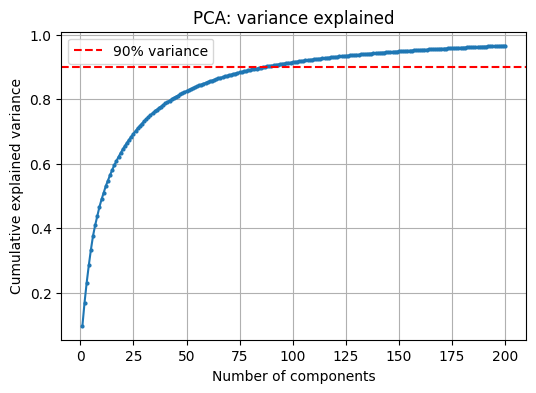

In [7]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, n_components+1), cum_var, marker='o', markersize=2)
plt.axhline(0.9, color='r', linestyle='--', label="90% variance")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA: variance explained')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error

ks = [5, 10, 20, 50, 100, 200]
mse_list = []

for k in ks:
    pca_k = PCA(n_components=k, svd_solver='randomized', random_state=42)
    Zk = pca_k.fit_transform(X)
    Xk = pca_k.inverse_transform(Zk)
    mse = mean_squared_error(X, Xk)
    mse_list.append(mse)
    print(f"k={k:3d}, Reconstruction MSE={mse:.6f}")


k=  5, Reconstruction MSE=0.044847
k= 10, Reconstruction MSE=0.034369
k= 20, Reconstruction MSE=0.023905
k= 50, Reconstruction MSE=0.011749
k=100, Reconstruction MSE=0.005746
k=200, Reconstruction MSE=0.002276


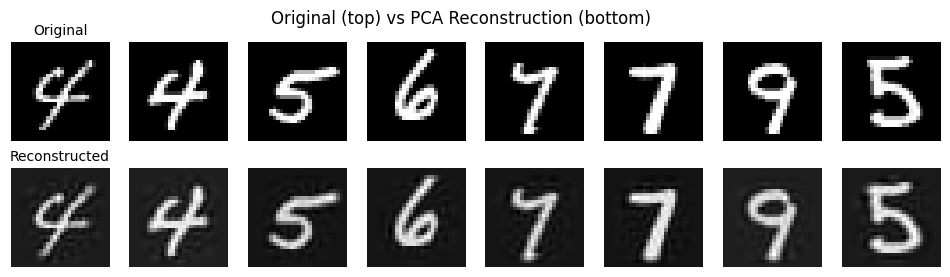

In [9]:
n_show = 8
indices = np.random.choice(n_samples, n_show, replace=False)

fig, axes = plt.subplots(2, n_show, figsize=(n_show*1.5, 3))

for i, idx in enumerate(indices):
    orig = X[idx].reshape(H, W)
    recon = pca.inverse_transform(Z[idx]).reshape(H, W)
    axes[0, i].imshow(orig, cmap='gray'); axes[0, i].axis('off')
    axes[1, i].imshow(recon, cmap='gray'); axes[1, i].axis('off')

axes[0,0].set_title("Original", fontsize=10)
axes[1,0].set_title("Reconstructed", fontsize=10)
plt.suptitle("Original (top) vs PCA Reconstruction (bottom)")
plt.show()


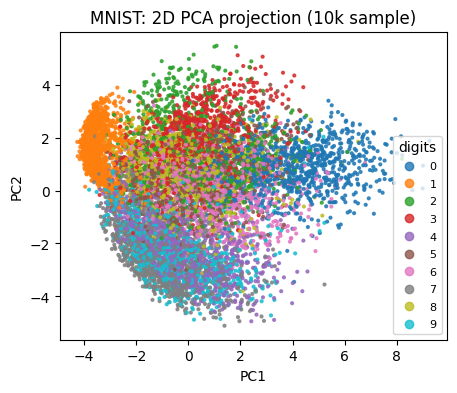

Trustworthiness (2D PCA, n_neighbors=5): 0.7343


In [10]:
# Subsample for visualization (e.g., 10k points)
idx = np.random.choice(len(X), 10000, replace=False)
X_small = X[idx]
y_small = y[idx]

pca2 = PCA(n_components=2, random_state=42)
Z2 = pca2.fit_transform(X_small)

plt.figure(figsize=(5,4))
scatter = plt.scatter(Z2[:,0], Z2[:,1], c=y_small, s=4, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="digits", loc="best", fontsize=8)
plt.title("MNIST: 2D PCA projection (10k sample)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Trustworthiness on the subset
tw = trustworthiness(X_small, Z2, n_neighbors=5)
print(f"Trustworthiness (2D PCA, n_neighbors=5): {tw:.4f}")


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [12]:
# We already have X (flattened images) and y (labels)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)

print("Training set shape:", X_train_full.shape)
print("Test set shape:", X_test_full.shape)


Training set shape: (60000, 784)
Test set shape: (10000, 784)


In [13]:
ks = [5, 10, 20, 50, 100, 200]
accuracy_list = []

for k in ks:
    # Fit PCA for current k
    pca_k = PCA(n_components=k, svd_solver='randomized', random_state=42)
    X_train_k = pca_k.fit_transform(X_train_full)
    X_test_k = pca_k.transform(X_test_full)
    
    # Train logistic regression
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    clf.fit(X_train_k, y_train_full)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test_k)
    acc = accuracy_score(y_test_full, y_pred)
    accuracy_list.append(acc)
    print(f"k={k:3d}, Test Accuracy={acc:.4f}")


k=  5, Test Accuracy=0.6803
k= 10, Test Accuracy=0.8053
k= 20, Test Accuracy=0.8764
k= 50, Test Accuracy=0.9098
k=100, Test Accuracy=0.9196
k=200, Test Accuracy=0.9219


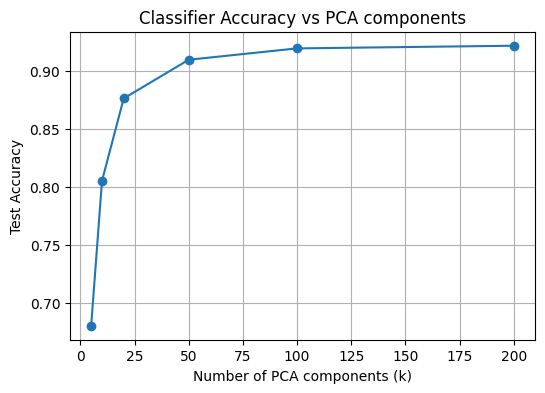

In [14]:
plt.figure(figsize=(6,4))
plt.plot(ks, accuracy_list, marker='o')
plt.xlabel('Number of PCA components (k)')
plt.ylabel('Test Accuracy')
plt.title('Classifier Accuracy vs PCA components')
plt.grid(True)
plt.show()


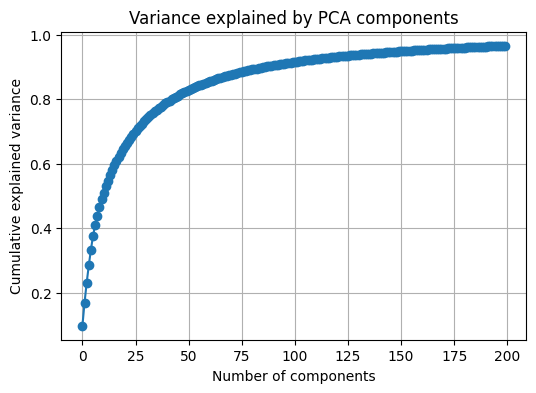

In [15]:
# Explained variance plot
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Variance explained by PCA components")
plt.grid(True)
plt.show()
